## Problem Statement

## Objective

The objective is to build various classification models, tune them, and find the best one that will help identify failures so that the generators could be repaired before failing/breaking to reduce the overall maintenance cost. 
The nature of predictions made by the classification model will translate as follows:

- True positives (TP) are failures correctly predicted by the model. These will result in repairing costs.
- False negatives (FN) are real failures where there is no detection by the model. These will result in replacement costs.
- False positives (FP) are detections where there is no failure. These will result in inspection costs.

It is given that the cost of repairing a generator is much less than the cost of replacing it, and the cost of inspection is less than the cost of repair.

“1” in the target variables should be considered as “failure” and “0” represents “No failure”.

## Data Description
- The data provided is a transformed version of original data which was collected using sensors.
- Both the datasets consist of 40 predictor variables and 1 target variable

## Importing necessary libraries

In [1]:
# To help with reading and manipulating data
import pandas as pd
import numpy as np

# To help with data visualization
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# To be used for missing value imputation
from sklearn.impute import SimpleImputer

# To help with model building
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    AdaBoostClassifier,
    GradientBoostingClassifier,
    RandomForestClassifier,
    BaggingClassifier,
)
from xgboost import XGBClassifier


# To get different metric scores, and split data
from sklearn import metrics
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score

from sklearn.metrics import (
    f1_score,
    accuracy_score,
    recall_score,
    precision_score,
    confusion_matrix,
    roc_auc_score)

# To be used for data scaling and one hot encoding
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder


#Oversampling and undersampling
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

# To be used for tuning the model
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# To be used for creating pipelines and personalizing them
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# To define maximum number of columns to be displayed in a dataframe
pd.set_option("display.max_columns", None)

# To supress scientific notations for a dataframe
pd.set_option("display.float_format", lambda x: "%.3f" % x)

# To supress warnings
import warnings

warnings.filterwarnings("ignore")



## Loading the dataset

In [2]:
#Importing the data
train_df=pd.read_csv("Train.csv.csv")
test_df=pd.read_csv("Test.csv.csv")

train_data=train_df.copy()
test_data=test_df.copy()
#Combining the train and test data to build one dataframe. 
data=pd.concat([train_data,test_data])

data.sample(10)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31,V32,V33,V34,V35,V36,V37,V38,V39,V40,Target
2395,-3.671,-2.823,1.393,-0.536,-1.608,0.224,-1.430,-1.008,-0.920,1.528,2.125,1.286,2.772,-0.174,-2.982,-0.226,-3.444,0.262,2.240,1.044,-1.143,-1.253,-2.436,-1.889,-1.632,-0.947,0.286,-0.695,2.200,3.233,-1.559,-1.063,2.973,2.441,2.305,1.485,0.379,0.188,2.094,-2.873,0
10452,2.534,3.378,1.417,2.550,-0.269,0.566,-0.621,-5.999,4.559,-0.232,-1.304,-4.052,2.578,-1.191,-3.722,-8.459,-1.383,-0.090,1.181,-1.331,-5.189,1.912,-2.364,-0.807,0.542,4.252,1.907,-0.127,-3.489,-3.398,-3.106,-2.213,-0.827,-0.576,0.630,-2.750,-1.800,3.262,0.689,-3.739,0
10178,-3.527,-1.545,1.392,-0.733,2.984,-2.289,-4.007,2.173,-0.378,-0.930,-7.046,1.333,3.864,0.848,-8.165,-3.411,1.784,6.428,-3.950,1.320,-5.795,3.225,5.701,5.965,-1.378,2.664,-5.885,-2.623,-3.440,1.477,3.752,10.482,1.919,-6.206,3.171,5.035,1.082,-6.220,0.511,-0.049,0
3759,-1.117,0.817,-5.130,0.878,0.027,-1.686,1.226,2.568,2.332,-3.470,0.844,3.723,5.879,1.600,-3.668,2.468,1.136,-0.800,-2.057,2.300,0.566,1.507,7.500,-3.843,-1.679,0.015,-1.387,-0.409,-1.670,-0.057,-6.178,0.026,-4.161,0.474,-4.408,-2.653,2.741,-2.591,0.151,-1.194,1
13931,2.082,0.270,0.846,-6.489,1.570,1.725,1.546,-1.897,-2.253,3.037,0.017,1.614,0.521,0.645,1.489,0.076,-5.284,2.120,-2.587,-6.727,0.344,1.001,0.097,0.581,0.792,1.992,6.405,-2.004,-3.135,-4.557,5.405,-0.730,-0.437,-1.409,-2.285,6.187,-0.575,3.265,2.450,2.263,0
3840,-4.189,-2.463,1.773,-2.306,2.926,-1.062,-4.948,-0.376,1.004,-0.504,-6.612,-0.713,6.257,1.380,-10.514,-5.337,-0.875,7.810,-5.978,0.914,-6.508,2.988,4.005,3.157,-1.291,3.277,-3.773,-3.795,-3.867,0.581,3.268,8.455,2.770,-6.794,1.941,6.575,1.354,-6.195,2.064,-0.539,1
1059,-0.853,-4.204,-0.327,2.918,1.231,-0.505,-3.169,2.532,-3.805,3.697,-6.421,-3.326,-9.683,0.596,2.428,-2.419,6.452,4.221,2.350,2.770,-0.639,3.082,2.094,13.936,0.787,-6.152,-5.715,4.142,-1.428,3.337,4.983,12.630,2.674,-2.126,6.925,1.100,-2.084,-1.132,-3.553,0.091,1
99,-4.014,-4.546,-0.002,2.305,-1.490,-1.464,-3.560,1.978,-0.606,0.665,-0.339,0.163,2.730,0.867,-5.582,-0.736,-0.289,1.440,2.025,4.107,-3.551,0.847,1.871,2.398,-2.509,-2.568,-4.693,-0.223,1.794,6.832,-1.350,7.119,4.339,-0.296,6.291,-0.467,0.005,-4.671,-0.626,-4.061,0
14746,-3.839,0.934,2.274,3.521,1.662,-0.849,-1.976,-2.409,1.867,0.302,-4.039,-3.137,0.952,-0.160,-3.428,-3.379,1.264,0.673,0.071,2.247,-0.788,-1.286,-2.801,0.992,-0.144,2.773,-2.429,0.291,-2.538,-2.532,-0.029,1.350,-0.223,0.637,-0.925,1.333,-0.417,-0.008,1.743,-2.800,0
1446,5.268,5.196,4.262,3.992,-2.676,0.251,-0.524,-5.686,2.718,-1.382,0.557,-0.435,-1.247,-5.594,-1.986,-11.761,1.023,-0.608,7.739,-2.154,-10.132,3.446,-4.055,3.387,0.196,4.239,-1.380,0.931,1.433,2.540,-4.683,-3.526,2.550,-0.578,8.750,-7.319,-2.802,6.291,-1.801,-3.381,0


## Data Overview

- Observations
- Sanity checks

In [3]:
data.shape

(25000, 41)

#### Observations
* The dataset has 25000 rows and 41 columns

In [4]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
V1,24977.000,-0.273,3.447,-12.382,-2.739,-0.750,1.838,15.493
V2,24976.000,0.432,3.149,-12.320,-1.643,0.465,2.527,14.079
V3,25000.000,2.498,3.377,-10.708,0.226,2.257,4.570,17.091
V4,25000.000,-0.076,3.428,-15.082,-2.338,-0.137,2.136,13.236
V5,25000.000,-0.059,2.106,-8.603,-1.549,-0.107,1.341,8.134
V6,25000.000,-1.005,2.034,-10.227,-2.352,-1.006,0.365,6.976
V7,25000.000,-0.885,1.763,-8.124,-2.036,-0.920,0.223,8.006
V8,25000.000,-0.553,3.303,-15.658,-2.643,-0.382,1.721,11.679
V9,25000.000,-0.007,2.163,-8.596,-1.486,-0.070,1.420,8.851
V10,25000.000,-0.007,2.184,-9.854,-1.400,0.111,1.484,8.108


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25000 entries, 0 to 4999
Data columns (total 41 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   V1      24977 non-null  float64
 1   V2      24976 non-null  float64
 2   V3      25000 non-null  float64
 3   V4      25000 non-null  float64
 4   V5      25000 non-null  float64
 5   V6      25000 non-null  float64
 6   V7      25000 non-null  float64
 7   V8      25000 non-null  float64
 8   V9      25000 non-null  float64
 9   V10     25000 non-null  float64
 10  V11     25000 non-null  float64
 11  V12     25000 non-null  float64
 12  V13     25000 non-null  float64
 13  V14     25000 non-null  float64
 14  V15     25000 non-null  float64
 15  V16     25000 non-null  float64
 16  V17     25000 non-null  float64
 17  V18     25000 non-null  float64
 18  V19     25000 non-null  float64
 19  V20     25000 non-null  float64
 20  V21     25000 non-null  float64
 21  V22     25000 non-null  float64
 22 

#### Observations
* All variables are numeric type variables

## Exploratory Data Analysis (EDA)

### Plotting histograms and boxplots for all the variables

In [6]:
# function to plot a boxplot and a histogram along the same scale.


def histogram_boxplot(data, feature, figsize=(12, 7), kde=False, bins=None):
    """
    Boxplot and histogram combined

    data: dataframe
    feature: dataframe column
    figsize: size of figure (default (12,7))
    kde: whether to the show density curve (default False)
    bins: number of bins for histogram (default None)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        data=data, x=feature, ax=ax_box2, showmeans=True, color="violet"
    )  # boxplot will be created and a star will indicate the mean value of the column
    sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2, bins=bins, palette="winter"
    ) if bins else sns.histplot(
        data=data, x=feature, kde=kde, ax=ax_hist2
    )  # For histogram
    ax_hist2.axvline(
        data[feature].mean(), color="green", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        data[feature].median(), color="black", linestyle="-"
    )  # Add median to the histogram

### Plotting all the features at one go

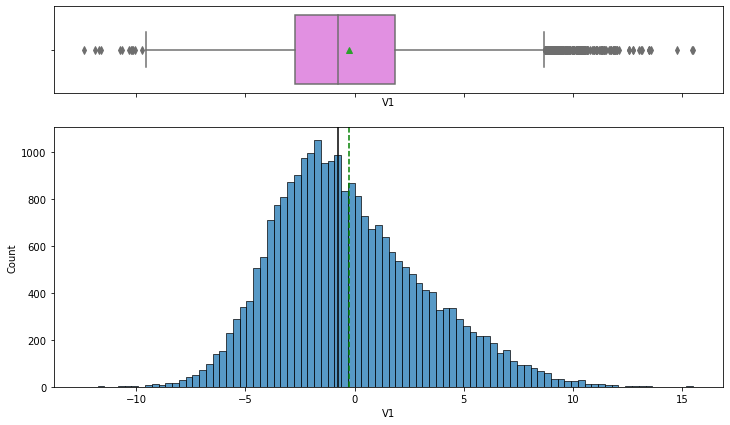

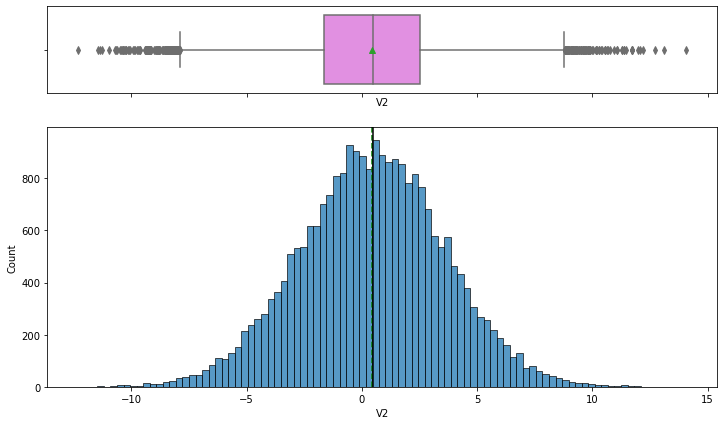

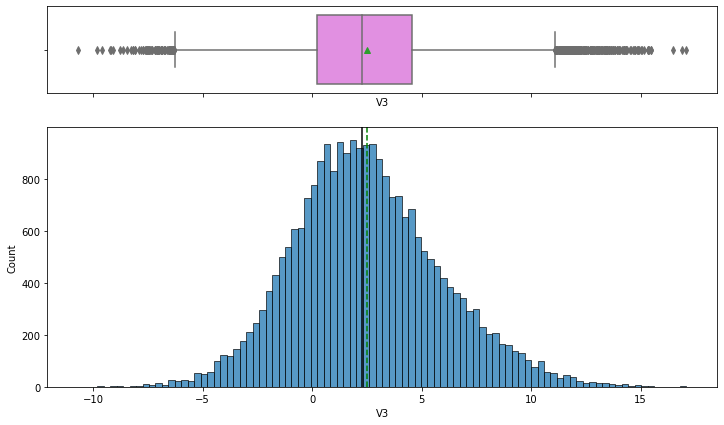

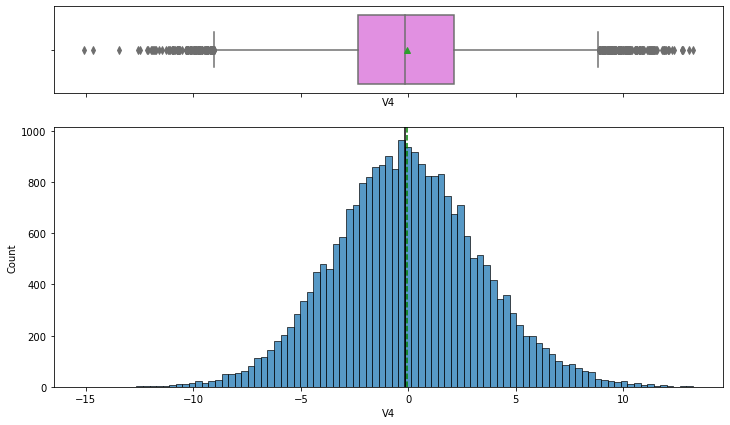

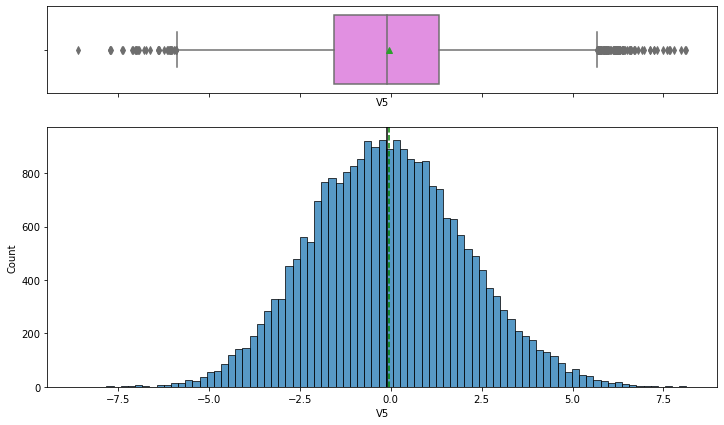

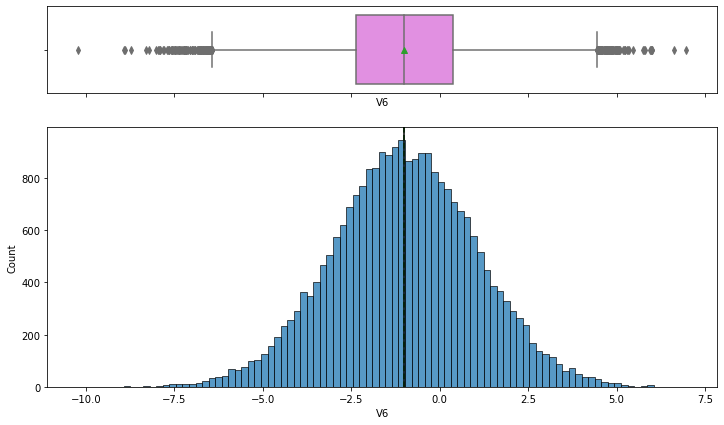

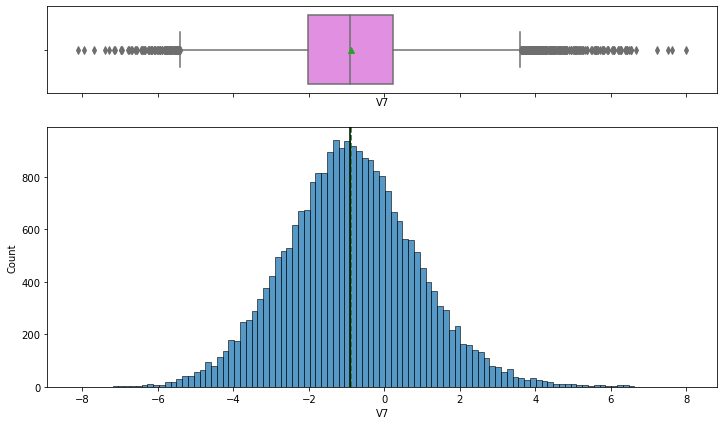

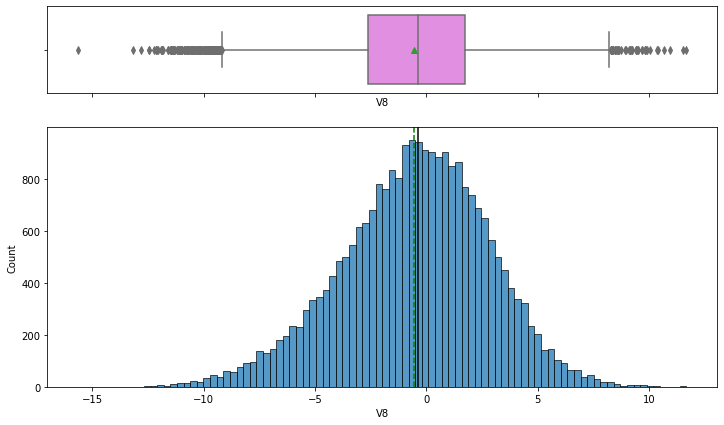

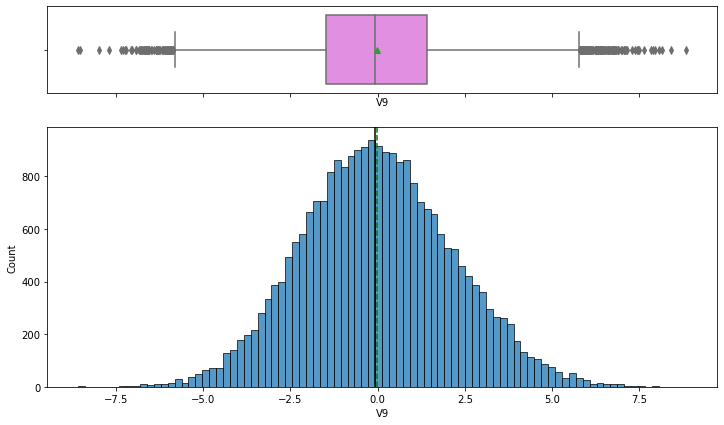

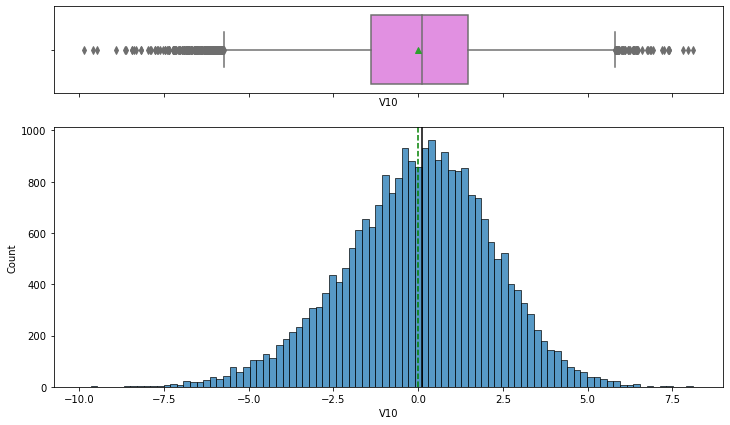

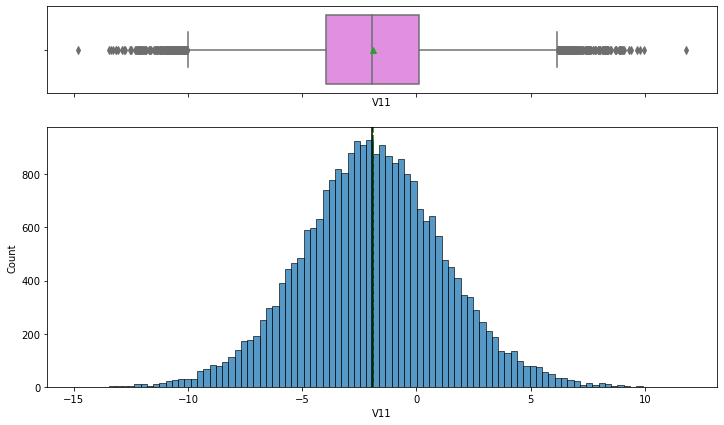

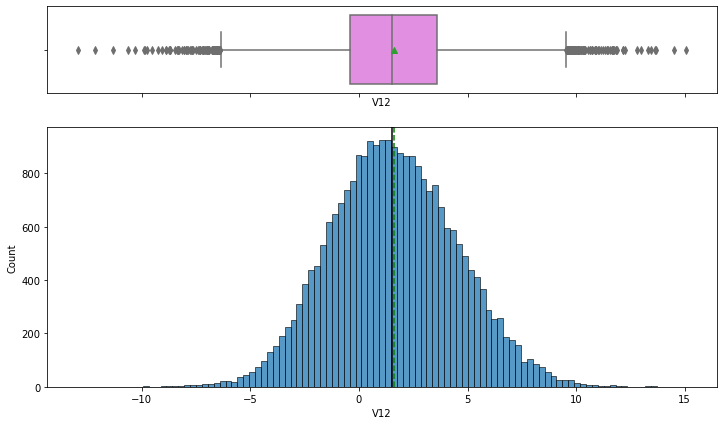

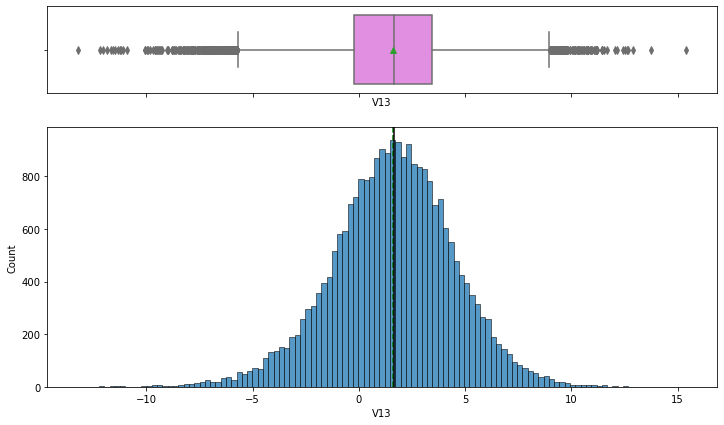

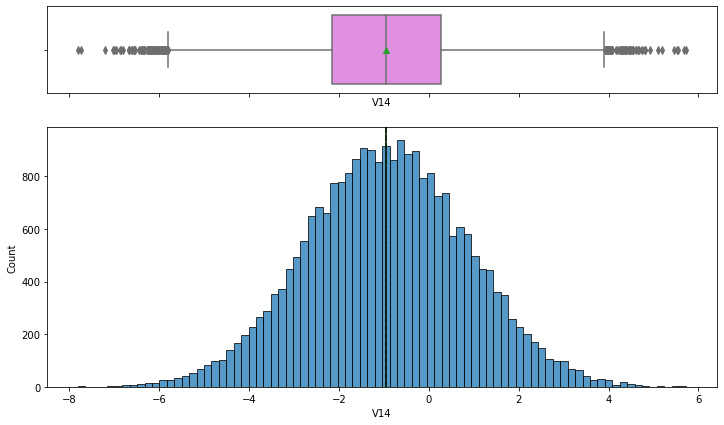

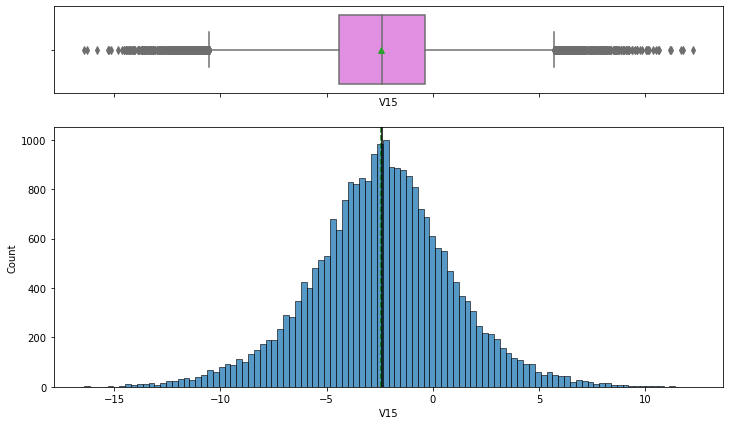

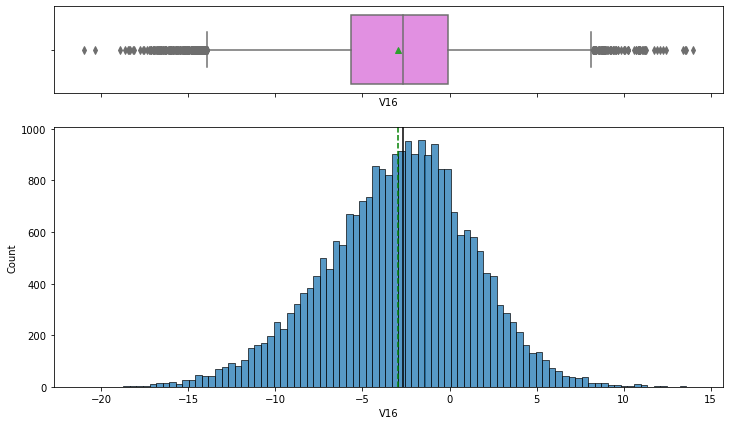

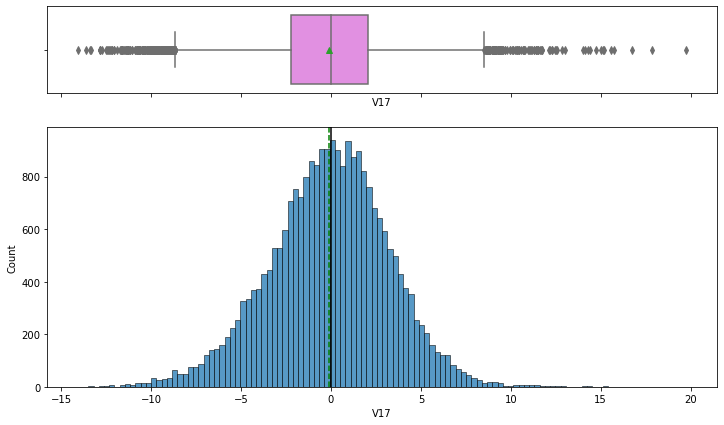

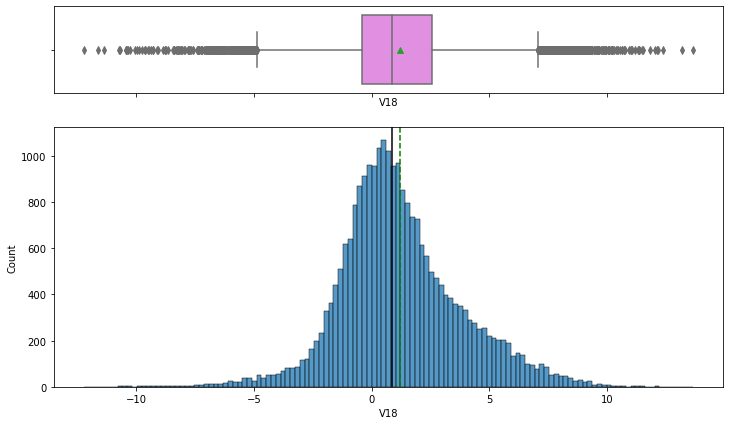

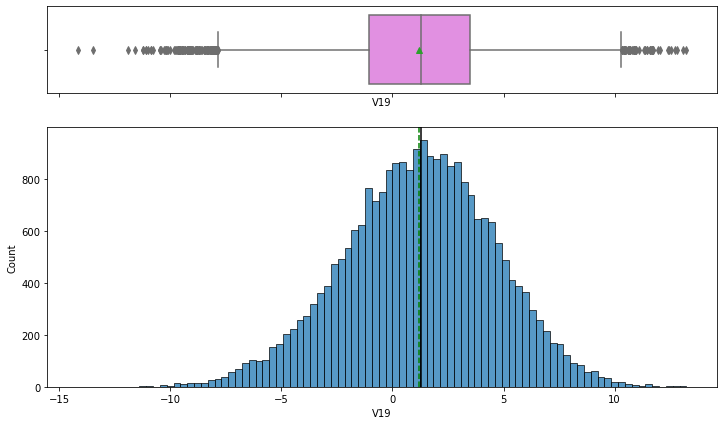

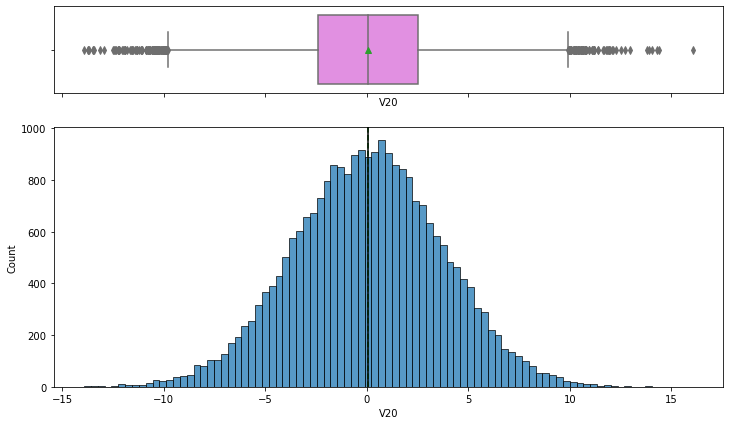

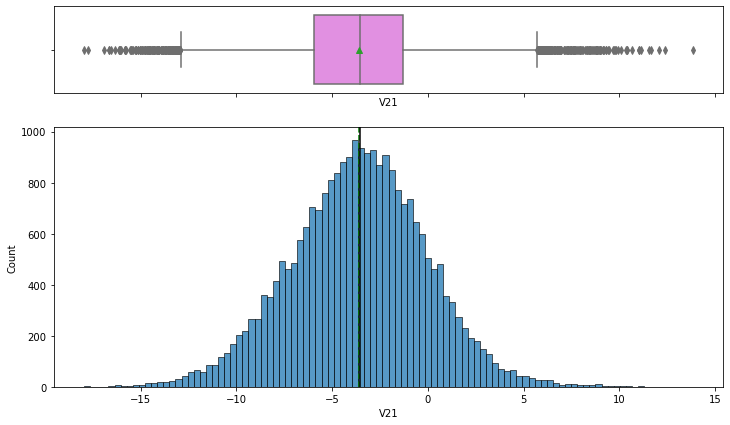

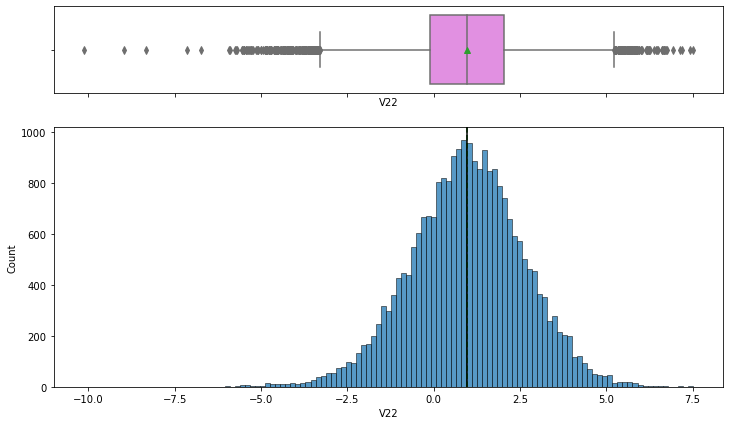

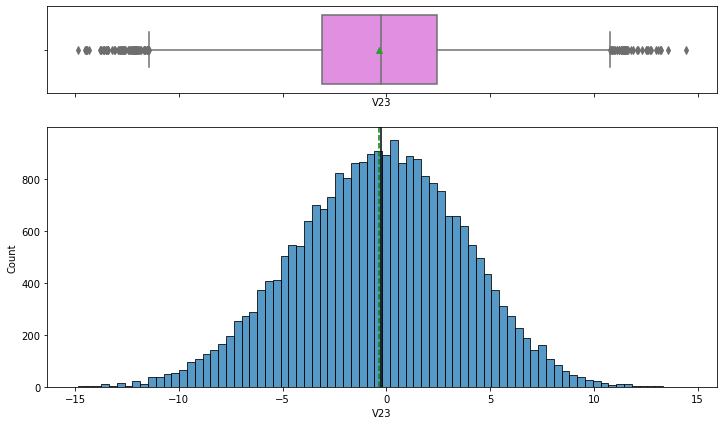

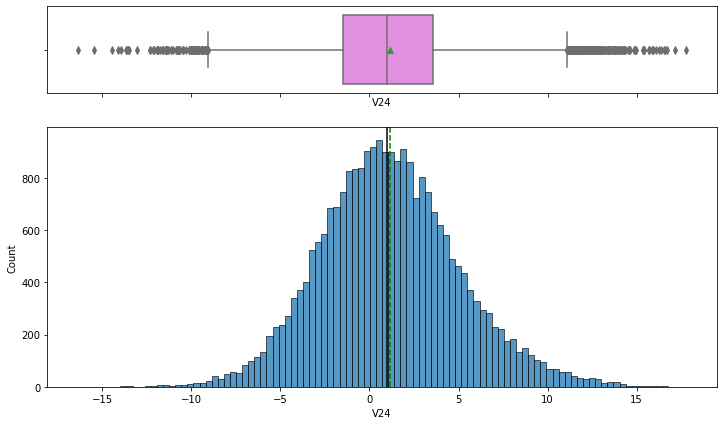

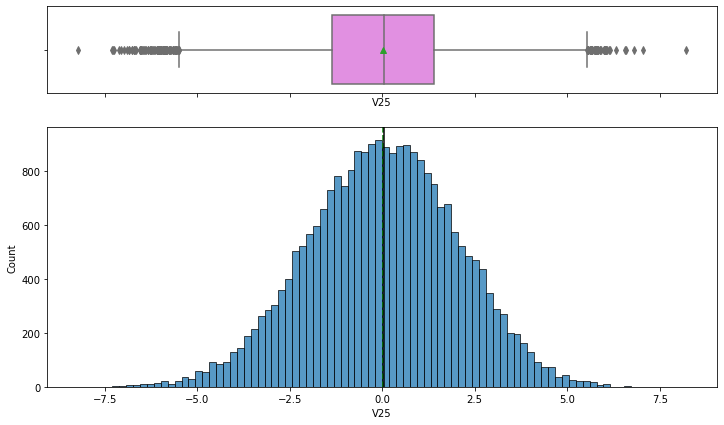

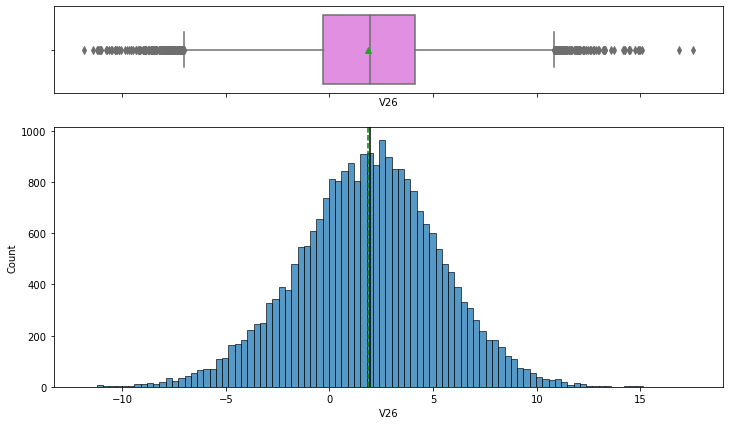

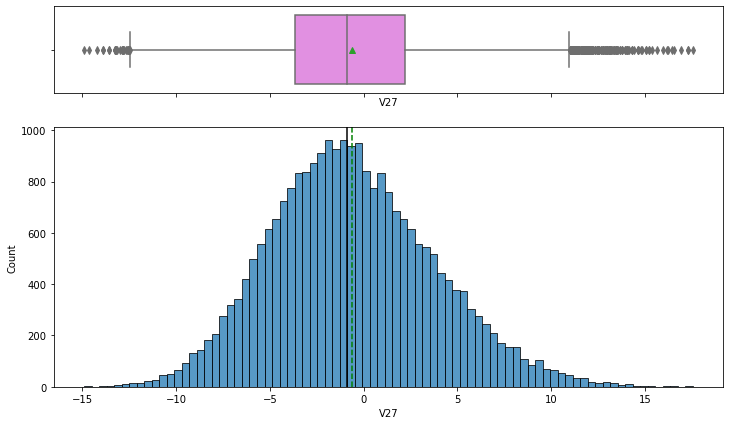

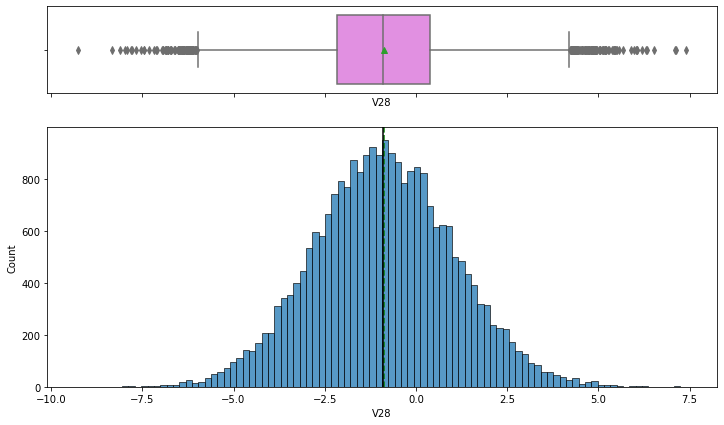

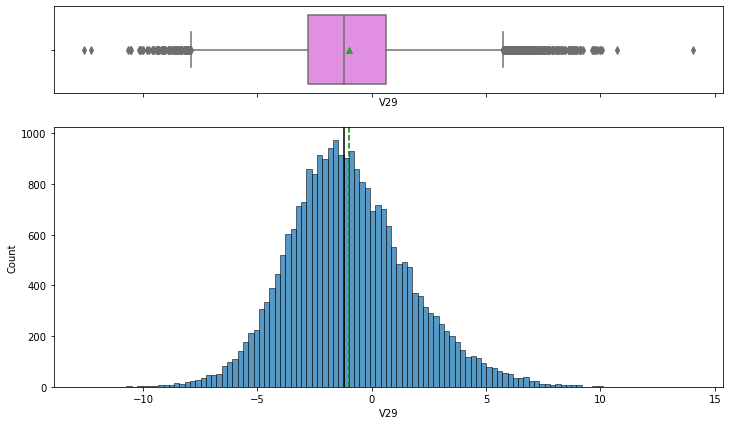

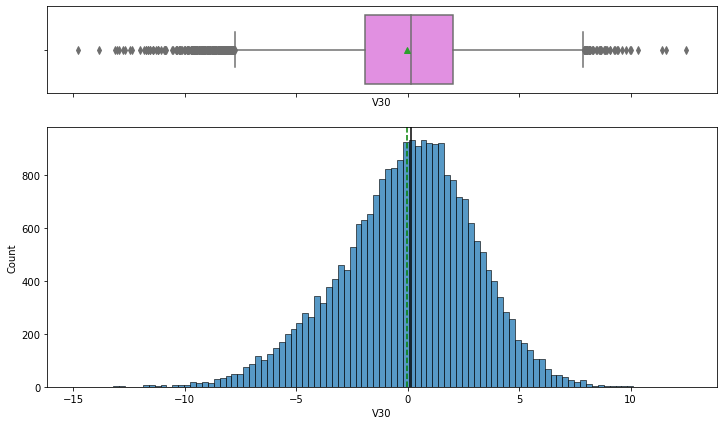

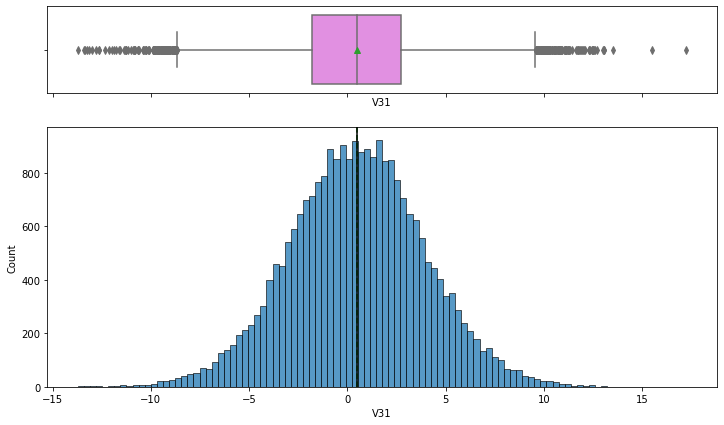

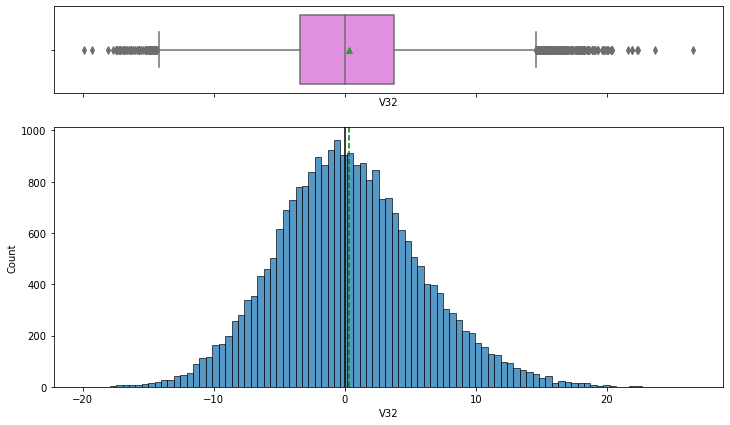

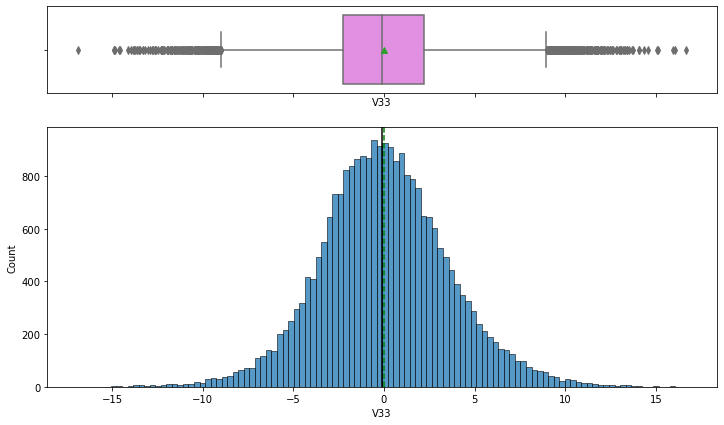

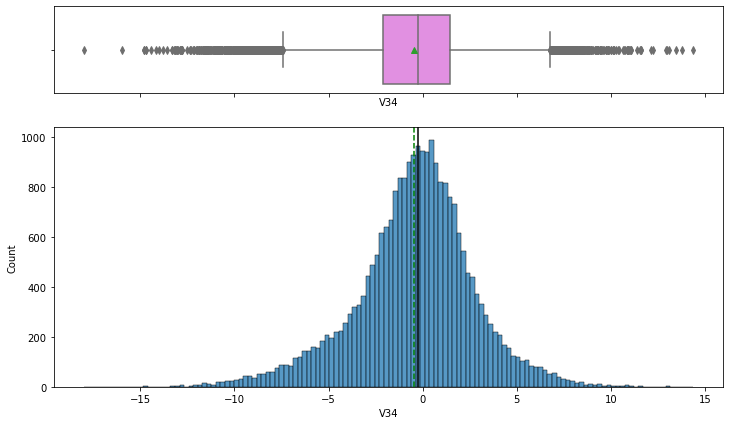

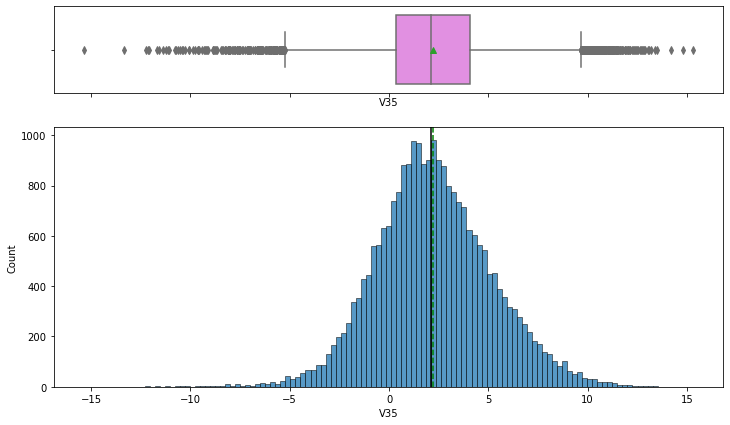

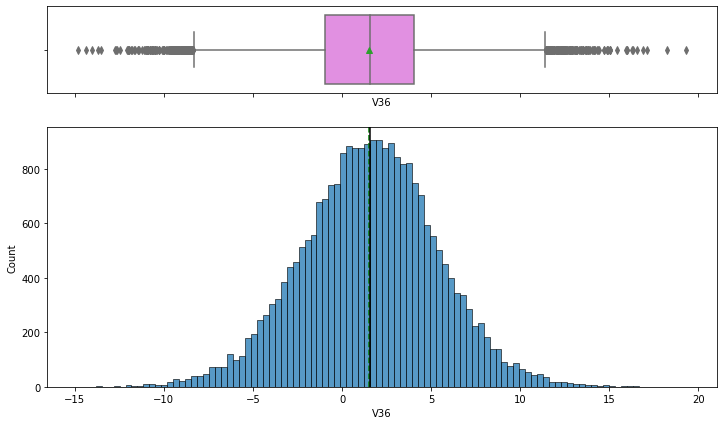

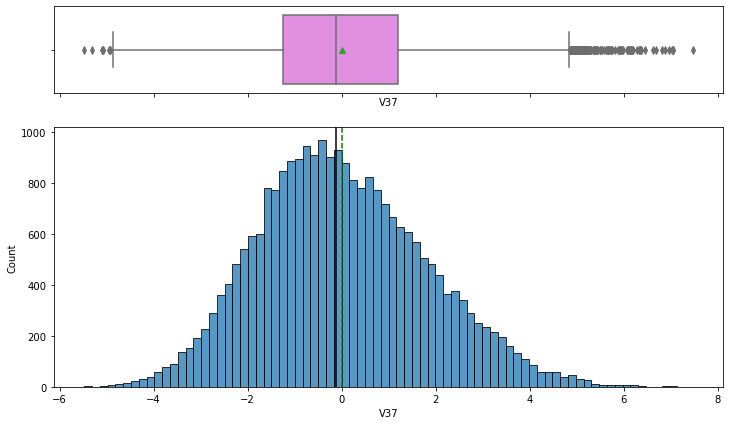

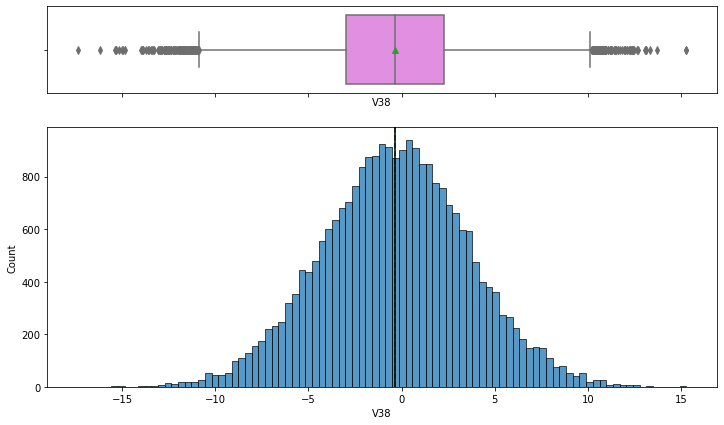

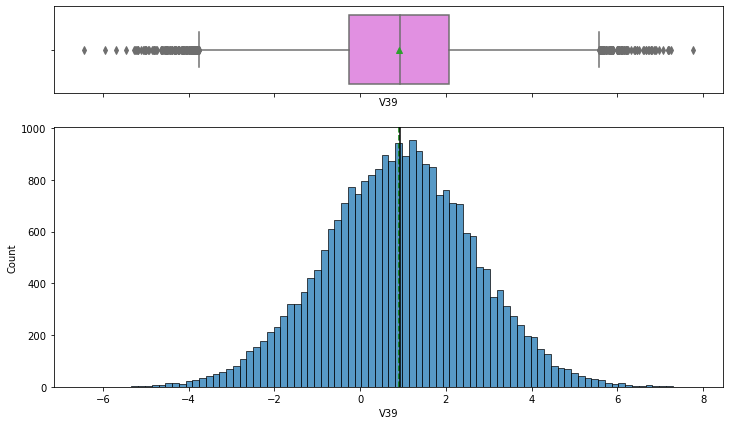

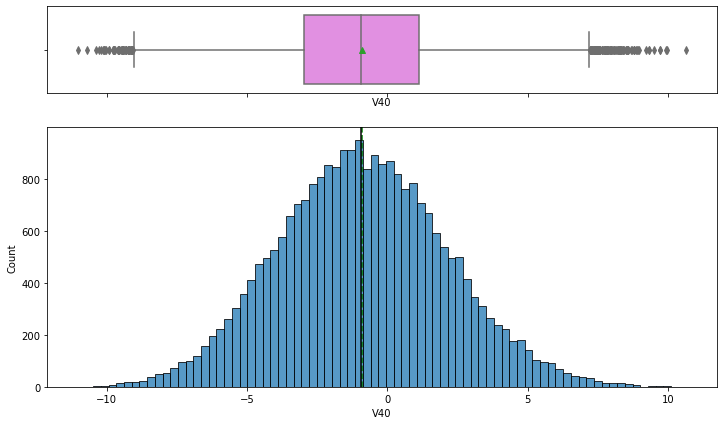

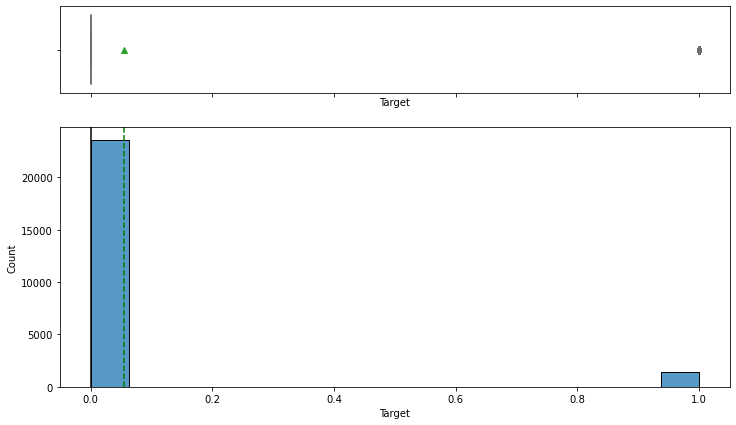

In [7]:
for feature in data.columns:
    histogram_boxplot(data, feature, figsize=(12, 7), kde=False, bins=None)

#### Observations
* The variables V1-V40 are normally distributed. 
* They all having varying levels of skewness.


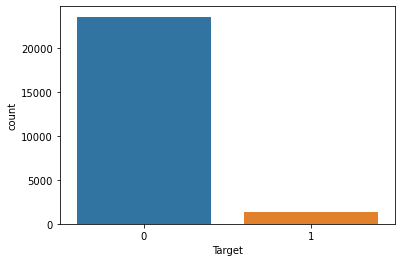

In [8]:
sns.countplot(data=data, x="Target");

### Bivariate Analysis

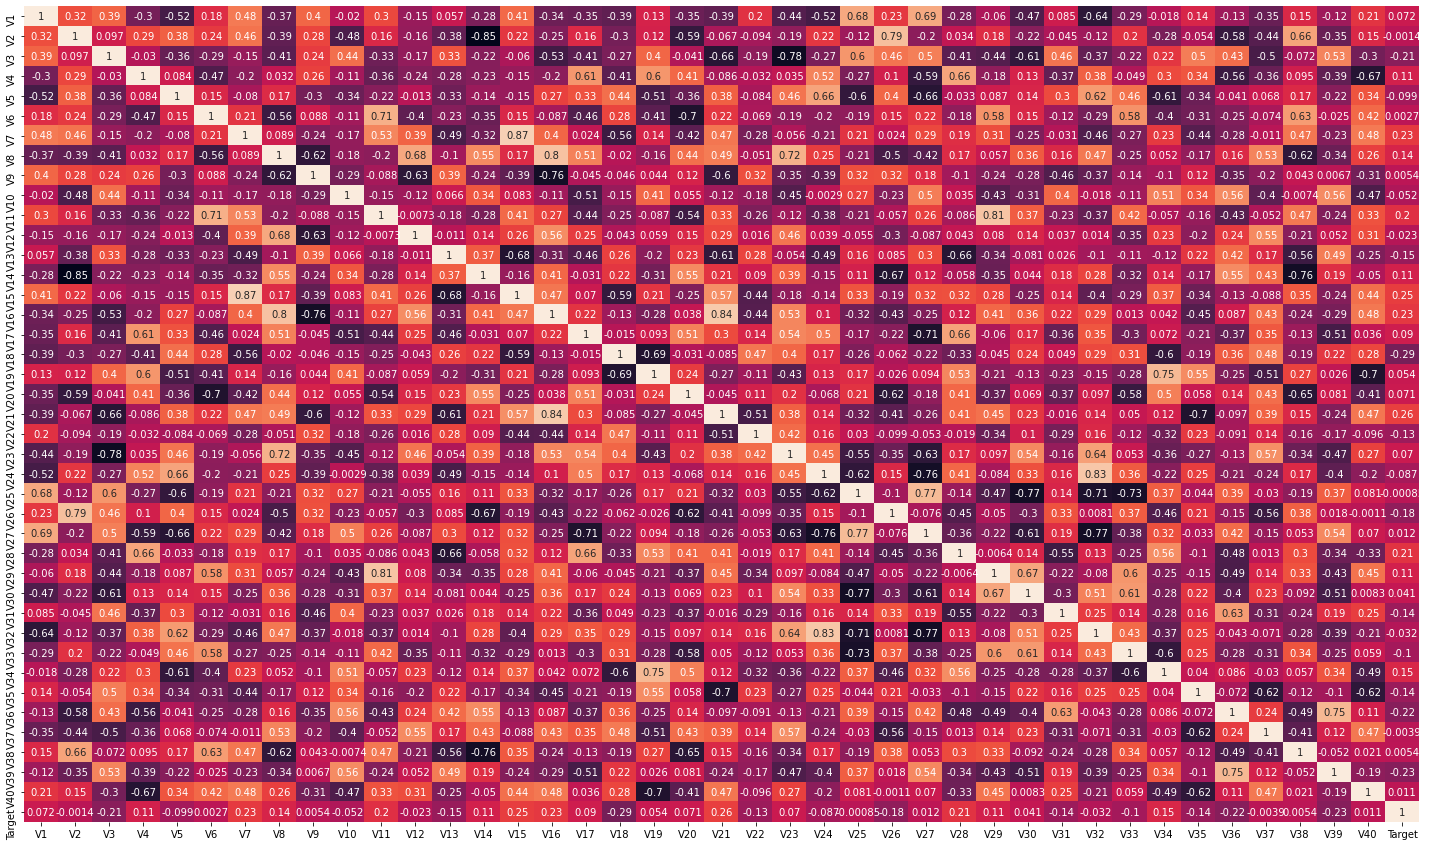

In [9]:
plt.figure(figsize=(25,15));
sns.heatmap(data=data.corr(), annot=True, cbar=False);


In [10]:
#Some variables have a greater correlation than 0.68. Ignoring the values of 1 between the same variables
d_corr=data.corr()[data.corr()>abs(0.68)]
print(d_corr)

          V1    V2    V3    V4    V5    V6    V7    V8    V9   V10   V11  \
V1     1.000   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   
V2       nan 1.000   nan   nan   nan   nan   nan   nan   nan   nan   nan   
V3       nan   nan 1.000   nan   nan   nan   nan   nan   nan   nan   nan   
V4       nan   nan   nan 1.000   nan   nan   nan   nan   nan   nan   nan   
V5       nan   nan   nan   nan 1.000   nan   nan   nan   nan   nan   nan   
V6       nan   nan   nan   nan   nan 1.000   nan   nan   nan   nan 0.711   
V7       nan   nan   nan   nan   nan   nan 1.000   nan   nan   nan   nan   
V8       nan   nan   nan   nan   nan   nan   nan 1.000   nan   nan   nan   
V9       nan   nan   nan   nan   nan   nan   nan   nan 1.000   nan   nan   
V10      nan   nan   nan   nan   nan   nan   nan   nan   nan 1.000   nan   
V11      nan   nan   nan   nan   nan 0.711   nan   nan   nan   nan 1.000   
V12      nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   
V13      nan

#### Observations
* The following variables had a correlation greater than 0.68(positve or negative). 
* V11 & V6
* V7 & V15
* V8 & V16
* V8 & V23
* V1 & V27
* V2 & V26
* V11 & V29
* V32 & V24
* V27 & V25
* V34 & V19 
* V36 & V39


## Data Pre-processing

In [11]:
# splitting the data into the dependent and independent variables
X = data.drop("Target", axis=1)
y = data["Target"]


In [12]:
# Splitting data into training, validation and test sets:
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1, stratify=y
)


X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=1, stratify=y_temp
)
print(X_train.shape, X_val.shape, X_test.shape)

(15000, 40) (5000, 40) (5000, 40)


#### Observations


* The training data will have 15000 rows and 40 columns
* The validation data will have 5000 rows and 40 columns
* The test data will have 5000 rows and 40 columns

## Missing value imputation




In [13]:
#Training data missing values
train_data.isnull().sum()

V1        18
V2        18
V3         0
V4         0
V5         0
V6         0
V7         0
V8         0
V9         0
V10        0
V11        0
V12        0
V13        0
V14        0
V15        0
V16        0
V17        0
V18        0
V19        0
V20        0
V21        0
V22        0
V23        0
V24        0
V25        0
V26        0
V27        0
V28        0
V29        0
V30        0
V31        0
V32        0
V33        0
V34        0
V35        0
V36        0
V37        0
V38        0
V39        0
V40        0
Target     0
dtype: int64

#### Observations
* Only V1 and V2 have missing data.

In [14]:
# Let's impute the missing values using the median value 
imp_mode = SimpleImputer(missing_values=np.nan, strategy="median")
cols_to_impute = ["V1", "V2"]

# fit and transform the imputer on train data
X_train[cols_to_impute] = imp_mode.fit_transform(X_train[cols_to_impute])

# Transform on validation and test data
X_val[cols_to_impute] = imp_mode.transform(X_val[cols_to_impute])

# fit and transform the imputer on test data
X_test[cols_to_impute] = imp_mode.transform(X_test[cols_to_impute])

In [15]:
# Checking that no column has missing values in train or test sets
print(X_train.isna().sum())
print("-" * 30)
print(X_val.isna().sum())
print("-" * 30)
print(X_test.isna().sum())

V1     0
V2     0
V3     0
V4     0
V5     0
V6     0
V7     0
V8     0
V9     0
V10    0
V11    0
V12    0
V13    0
V14    0
V15    0
V16    0
V17    0
V18    0
V19    0
V20    0
V21    0
V22    0
V23    0
V24    0
V25    0
V26    0
V27    0
V28    0
V29    0
V30    0
V31    0
V32    0
V33    0
V34    0
V35    0
V36    0
V37    0
V38    0
V39    0
V40    0
dtype: int64
------------------------------
V1     0
V2     0
V3     0
V4     0
V5     0
V6     0
V7     0
V8     0
V9     0
V10    0
V11    0
V12    0
V13    0
V14    0
V15    0
V16    0
V17    0
V18    0
V19    0
V20    0
V21    0
V22    0
V23    0
V24    0
V25    0
V26    0
V27    0
V28    0
V29    0
V30    0
V31    0
V32    0
V33    0
V34    0
V35    0
V36    0
V37    0
V38    0
V39    0
V40    0
dtype: int64
------------------------------
V1     0
V2     0
V3     0
V4     0
V5     0
V6     0
V7     0
V8     0
V9     0
V10    0
V11    0
V12    0
V13    0
V14    0
V15    0
V16    0
V17    0
V18    0
V19    0
V20    0
V21    0
V22

#### Observations
* There are no missing values

## Model Building

### Model evaluation criterion

The nature of predictions made by the classification model will translate as follows:

- True positives (TP) are failures correctly predicted by the model.
- False negatives (FN) are real failures in a generator where there is no detection by model. 
- False positives (FP) are failure detections in a generator where there is no failure.

**Which metric to optimize?**

* We need to choose the metric which will ensure that the maximum number of generator failures are predicted correctly by the model.
* We would want Recall to be maximized as greater the Recall, the higher the chances of minimizing false negatives.
* We want to minimize false negatives because if a model predicts that a machine will have no failure when there will be a failure, it will increase the maintenance cost.

**Let's define a function to output different metrics (including recall) on the train and test set and a function to show confusion matrix so that we do not have to use the same code repetitively while evaluating models.**

In [16]:
# defining a function to compute different metrics to check performance of a classification model built using sklearn
def model_performance_classification_sklearn(model, predictors, target):
    """
    Function to compute different metrics to check classification model performance

    model: classifier
    predictors: independent variables
    target: dependent variable
    """

    # predicting using the independent variables
    pred = model.predict(predictors)
  
    acc = accuracy_score(target, pred)  # to compute Accuracy
    recall = recall_score(target, pred)  # to compute Recall
    precision = precision_score(target, pred)  # to compute Precision
    f1 = f1_score(target, pred)  # to compute F1-score

    # creating a dataframe of metrics
    df_perf = pd.DataFrame(
        {
            "Accuracy": acc,
            "Recall": recall,
            "Precision": precision,
            "F1": f1
            
        },
        index=[0],
    )

    return df_perf

In [17]:
def confusion_matrix_sklearn(model, predictors, target):
    """
    To plot the confusion_matrix with percentages

    model: classifier
    predictors: independent variables
    target: dependent variable
    """
    y_pred = model.predict(predictors)
    cm = confusion_matrix(target, y_pred)
    labels = np.asarray(
        [
            ["{0:0.0f}".format(item) + "\n{0:.2%}".format(item / cm.flatten().sum())]
            for item in cm.flatten()
        ]
    ).reshape(2, 2)

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=labels, fmt="")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

### Defining scorer to be used for cross-validation and hyperparameter tuning

- We want to reduce false negatives and will try to maximize "Recall".
- To maximize Recall, we can use Recall as a **scorer** in cross-validation and hyperparameter tuning.

In [18]:
# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.recall_score)

### Model Building with original data

Sample Decision Tree model building with original data 

In [19]:
models = []  # Empty list to store all the models

# Appending models into the list
models.append(("dtree", DecisionTreeClassifier(random_state=1)))
models.append(("Bagging", BaggingClassifier(random_state=1)))
models.append(("Random forest", RandomForestClassifier(random_state=1)))
models.append(("GBM", GradientBoostingClassifier(random_state=1)))
models.append(("Adaboost", AdaBoostClassifier(random_state=1)))
models.append(("Xgboost", XGBClassifier(random_state=1, eval_metric="logloss")))
models.append(("dtree", DecisionTreeClassifier(random_state=1)))

results1 = []  # Empty list to store all model's CV scores
names = []  # Empty list to store name of the models


# loop through all models to get the mean cross validated score
print("\n" "Cross-Validation performance on training dataset:" "\n")

for name, model in models:
    kfold = StratifiedKFold(
        n_splits=5, shuffle=True, random_state=1
    )  # Setting number of splits equal to 5
    cv_result = cross_val_score(
        estimator=model, X=X_train, y=y_train, scoring=scorer, cv=kfold
    )
    results1.append(cv_result)
    names.append(name)
    print("{}: {}".format(name, cv_result.mean()))

print("\n" "Validation Performance:" "\n")

for name, model in models:
    model.fit(X_train, y_train)
    scores = recall_score(y_val, model.predict(X_val))
    print("{}: {}".format(name, scores))


Cross-Validation performance on training dataset:

dtree: 0.7089820359281437
Bagging: 0.7077844311377245
Random forest: 0.7137724550898203
GBM: 0.7077844311377246
Adaboost: 0.6011976047904192
Xgboost: 0.7976047904191617
dtree: 0.7089820359281437

Validation Performance:

dtree: 0.6845878136200717
Bagging: 0.6774193548387096
Random forest: 0.7204301075268817
GBM: 0.6953405017921147
Adaboost: 0.5734767025089605
Xgboost: 0.7885304659498208
dtree: 0.6845878136200717


#### Observations
* Based on the recall, the best models were those built by:
    1. Random Forest
    2. XGBoost
    3. Gradient Boosting

### Model Building with Oversampled data


In [20]:
# Synthetic Minority Over Sampling Technique

sm = SMOTE(sampling_strategy=1, k_neighbors=5, random_state=1)
X_train_over, y_train_over = sm.fit_resample(X_train, y_train)

In [21]:
print("The non-target variable has", X_train_over.shape[0], "rows and ", X_train_over.shape[1], "columns")
print("The target variable now has", y_train_over.shape[0], "rows and 1 column")

The non-target variable has 28330 rows and  40 columns
The target variable now has 28330 rows and 1 column


In [22]:
over_models = []  # Empty list to store all the over_models

# Appending over_models into the list
over_models.append(("dtree", DecisionTreeClassifier(random_state=1)))
over_models.append(("Bagging", BaggingClassifier(random_state=1)))
over_models.append(("Random forest", RandomForestClassifier(random_state=1)))
over_models.append(("GBM", GradientBoostingClassifier(random_state=1)))
over_models.append(("Adaboost", AdaBoostClassifier(random_state=1)))
over_models.append(("Xgboost", XGBClassifier(random_state=1, eval_metric="logloss")))
over_models.append(("dtree", DecisionTreeClassifier(random_state=1)))

results1 = []  # Empty list to store all model's CV scores
names = []  # Empty list to store name of the over_models


# loop through all over_models to get the mean cross validated score
print("\n" "Cross-Validation performance on over sampled training dataset:" "\n")

for name, model in over_models:
    kfold = StratifiedKFold(
        n_splits=5, shuffle=True, random_state=1
    )  # Setting number of splits equal to 5
    cv_result = cross_val_score(
        estimator=model, X=X_train_over, y=y_train_over, scoring=scorer, cv=kfold
    )
    results1.append(cv_result)
    names.append(name)
    print("{}: {}".format(name, cv_result.mean()))

print("\n" "Validation Performance:" "\n")

for name, model in over_models:
    model.fit(X_train_over, y_train_over)
    scores = recall_score(y_val, model.predict(X_val))
    print("{}: {}".format(name, scores))


Cross-Validation performance on over sampled training dataset:

dtree: 0.9695728909283445
Bagging: 0.974302859159901
Random forest: 0.9833392163783975
GBM: 0.9182492057889163
Adaboost: 0.8924814684080481
Xgboost: 0.9903988704553477
dtree: 0.9695728909283445

Validation Performance:

dtree: 0.7347670250896058
Bagging: 0.7526881720430108
Random forest: 0.8243727598566308
GBM: 0.8673835125448028
Adaboost: 0.8172043010752689
Xgboost: 0.8566308243727598
dtree: 0.7347670250896058


#### Observation
* After using Sythentic Minority Oversampling Technique(SMOTE), the target and non target variable have the same number of records.
* The best perfoming classifiers are:
    1. Xgboost
    2. Gradient boosting
    3. Random Forests

### Model Building with Undersampled data

In [23]:
# Random undersampler for under sampling the data
rus = RandomUnderSampler(random_state=1, sampling_strategy=1)
X_train_un, y_train_un = rus.fit_resample(X_train, y_train)

In [24]:
print("The non-target variable has", X_train_un.shape[0], "rows and ", X_train_un.shape[1], "columns")
print("The target variable now has", y_train_un.shape[0], "rows and 1 column")

The non-target variable has 1670 rows and  40 columns
The target variable now has 1670 rows and 1 column


In [25]:
under_models = []  # Empty list to store all the under_models

# Appending under_models into the list
under_models.append(("dtree", DecisionTreeClassifier(random_state=1)))
under_models.append(("Bagging", BaggingClassifier(random_state=1)))
under_models.append(("Random forest", RandomForestClassifier(random_state=1)))
under_models.append(("GBM", GradientBoostingClassifier(random_state=1)))
under_models.append(("Adaboost", AdaBoostClassifier(random_state=1)))
under_models.append(("Xgboost", XGBClassifier(random_state=1, eval_metric="logloss")))
under_models.append(("dtree", DecisionTreeClassifier(random_state=1)))

results1 = []  # Empty list to store all model's CV scores
names = []  # Empty list to store name of the under_models


# loop through all under_models to get the mean cross validated score
print("\n" "Cross-Validation performance on under sampled training dataset:" "\n")

for name, model in under_models:
    kfold = StratifiedKFold(
        n_splits=5, shuffle=True, random_state=1
    )  # Setting number of splits equal to 5
    cv_result = cross_val_score(
        estimator=model, X=X_train_un, y=y_train_un, scoring=scorer, cv=kfold
    )
    results1.append(cv_result)
    names.append(name)
    print("{}: {}".format(name, cv_result.mean()))

print("\n" "Validation Performance:" "\n")

for name, model in under_models:
    model.fit(X_train_un, y_train_un)
    scores = recall_score(y_val, model.predict(X_val))
    print("{}: {}".format(name, scores))


Cross-Validation performance on under sampled training dataset:

dtree: 0.8359281437125748
Bagging: 0.8658682634730539
Random forest: 0.895808383233533
GBM: 0.881437125748503
Adaboost: 0.8598802395209582
Xgboost: 0.8934131736526945
dtree: 0.8359281437125748

Validation Performance:

dtree: 0.8136200716845878
Bagging: 0.8207885304659498
Random forest: 0.8709677419354839
GBM: 0.8673835125448028
Adaboost: 0.8530465949820788
Xgboost: 0.8781362007168458
dtree: 0.8136200716845878


#### Observations
* The target and non target variable had the same  number of records
* Based on their recall scores, the best perfoming classifier are:
    1. Xgboost
    2. Random Forests
    3. Gradient boosting

## HyperparameterTuning 

### Sample Parameter Grids

**Hyperparameter tuning can take a long time to run, so to avoid that time complexity - you can use the following grids, wherever required.**

- For Gradient Boosting:

param_grid = {
    "n_estimators": np.arange(100,150,25),
    "learning_rate": [0.2, 0.05, 1],
    "subsample":[0.5,0.7], 
    "max_features":[0.5,0.7]
}

- For Adaboost:

param_grid = {
    "n_estimators": [100, 150, 200],
    "learning_rate": [0.2, 0.05],
    "base_estimator": [DecisionTreeClassifier(max_depth=1, random_state=1), DecisionTreeClassifier(max_depth=2, random_state=1), DecisionTreeClassifier(max_depth=3, random_state=1),
    ]
}

- For Bagging Classifier:

param_grid = {
    'max_samples': [0.8,0.9,1], 
    'max_features': [0.7,0.8,0.9],
    'n_estimators' : [30,50,70],
}

- For Random Forest:

param_grid = {
    "n_estimators": [200,250,300],
    "min_samples_leaf": np.arange(1, 4),
    "max_features": [np.arange(0.3, 0.6, 0.1),'sqrt'],
    "max_samples": np.arange(0.4, 0.7, 0.1)
}

- For Decision Trees:

param_grid = {
    'max_depth': np.arange(2,6), 
    'min_samples_leaf': [1, 4, 7],
    'max_leaf_nodes' : [10, 15],
    'min_impurity_decrease': [0.0001,0.001]
}

- For Logistic Regression:

param_grid = {'C': np.arange(0.1,1.1,0.1)}

- For XGBoost:

param_grid={
    'n_estimators': [150, 200, 250],
    'scale_pos_weight': [5,10],
    'learning_rate': [0.1,0.2],
    'gamma': [0,3,5],
    'subsample': [0.8,0.9]
}

**Based on their perfomance on original, undersampled and oversampled data, the models chosen for hypertuning are:<br/>
    1. Random Forests<br/>
    2. XGBoost <br/>
    3. Gradient Boosting**

### Random Forest tuning with Random Search CV

#### 1. Original data

In [26]:
# defining model
original_rf_model = RandomForestClassifier(random_state=1)

# Parameter grid to pass in RandomSearchCV
param_grid = { "n_estimators": [200,250,300], "min_samples_leaf": np.arange(1, 4), "max_features": [np.arange(0.3, 0.6, 0.1),'sqrt'], "max_samples": np.arange(0.4, 0.7, 0.1) }
#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=original_rf_model, param_distributions=param_grid, n_iter=10, n_jobs = -1, scoring=scorer, cv=5, random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train,y_train)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'n_estimators': 300, 'min_samples_leaf': 1, 'max_samples': 0.6, 'max_features': 'sqrt'} with CV score=0.6994011976047905:


In [27]:
# building model with best parameters
rf_tuned_train =RandomForestClassifier(random_state=1,
   n_estimators= 300, min_samples_leaf= 1, max_samples= 0.6, max_features= 'sqrt'
)

# Fit the model on training data
rf_tuned_train.fit(X_train, y_train)

RandomForestClassifier(max_samples=0.6, n_estimators=300, random_state=1)

In [28]:
# Calculating different metrics on train set
rf_ideal_train = model_performance_classification_sklearn(
    rf_tuned_train, X_train, y_train
)
print("Training performance:")
rf_ideal_train

Training performance:


,Accuracy,Recall,Precision,F1
0,0.995,0.902,1.000,0.948


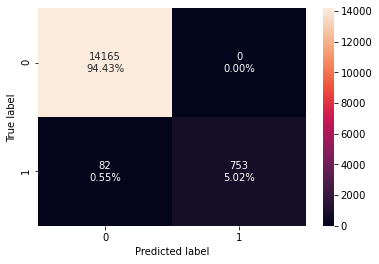

In [29]:
confusion_matrix_sklearn(rf_tuned_train, X_train, y_train)

In [30]:
#Testing perfomance on validation 
rf_tuned_val =RandomForestClassifier(random_state=1,
   n_estimators= 300, min_samples_leaf= 1, max_samples= 0.6, max_features= 'sqrt'
)

# Fit the model on training data
rf_tuned_val.fit(X_val, y_val)

RandomForestClassifier(max_samples=0.6, n_estimators=300, random_state=1)

In [31]:
rf_ideal_val = model_performance_classification_sklearn(
   rf_tuned_val, X_val, y_val
)
print("Validation performance:")
rf_ideal_val

Validation performance:


,Accuracy,Recall,Precision,F1
0,0.993,0.875,1.000,0.933


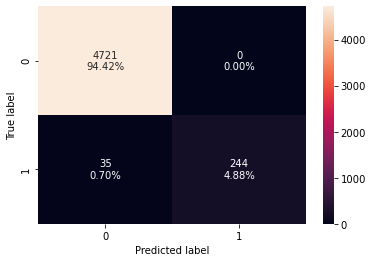

In [32]:
confusion_matrix_sklearn(rf_tuned_val, X_val, y_val)

#### 2. Oversampled Data

In [33]:
# defining model
over_rf_model = RandomForestClassifier(random_state=1)

# Parameter grid to pass in RandomSearchCV
param_grid = {"n_estimators": [200,250,300], "min_samples_leaf": np.arange(1, 4), "max_features": [np.arange(0.3, 0.6, 0.1),'sqrt'], "max_samples": np.arange(0.4, 0.7, 0.1) }


#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=over_rf_model, param_distributions=param_grid, n_iter=10, n_jobs = -1, scoring=scorer, cv=5, random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train_over,y_train_over)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'n_estimators': 250, 'min_samples_leaf': 1, 'max_samples': 0.6, 'max_features': 'sqrt'} with CV score=0.9807977409106954:


In [34]:
# building model with best parameters
rf_tuned_over =RandomForestClassifier(random_state=1,
   n_estimators= 250, min_samples_leaf= 1, max_samples= 0.6, max_features= 'sqrt'
)

# Fit the model on training data
rf_tuned_over.fit(X_train_over, y_train_over)

RandomForestClassifier(max_samples=0.6, n_estimators=250, random_state=1)

In [35]:
# Calculating different metrics on train set
rf_ideal_over = model_performance_classification_sklearn(
    rf_tuned_over, X_train_over, y_train_over
)
print("Oversampled data performance:")
rf_ideal_over

Oversampled data performance:


,Accuracy,Recall,Precision,F1
0,1.000,1.000,1.000,1.000


#### 3. Undersampled data

In [36]:
# defining model
under_rf_model = RandomForestClassifier(random_state=1)

# Parameter grid to pass in RandomSearchCV
param_grid = {"n_estimators": [200,250,300], "min_samples_leaf": np.arange(1, 4), "max_features": [np.arange(0.3, 0.6, 0.1),'sqrt'], "max_samples": np.arange(0.4, 0.7, 0.1) } 


#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=under_rf_model, param_distributions=param_grid, n_iter=10, n_jobs = -1, scoring=scorer, cv=5, random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train_un,y_train_un)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'n_estimators': 300, 'min_samples_leaf': 1, 'max_samples': 0.6, 'max_features': 'sqrt'} with CV score=0.8874251497005989:


In [37]:
# building model with best parameters
rf_tuned_un =RandomForestClassifier(random_state=1,
   n_estimators= 300, min_samples_leaf= 1, max_samples= 0.6, max_features= 'sqrt'
)

# Fit the model on training data
rf_tuned_un.fit(X_train_un, y_train_un)

RandomForestClassifier(max_samples=0.6, n_estimators=300, random_state=1)

In [38]:
# Calculating different metrics on train set
rf_ideal_un = model_performance_classification_sklearn(
    rf_tuned_un, X_train_un, y_train_un
)
print("Undersampled data performance:")
rf_ideal_un

Undersampled data performance:


,Accuracy,Recall,Precision,F1
0,0.988,0.976,1.000,0.988


#### Observations
* The model trained on the original data set has the lowest recall score for Random Forestss.
* The best perfoming model was the one trained on oversampled data. However this has the tendancy to overfit. 


### XGBoost tuning with Random Search CV on:

#### 1. Original Data

In [39]:
# defining model
xgb_model = XGBClassifier(random_state=1, eval_metric="logloss")

# Parameter grid to pass in RandomSearchCV
param_grid = {'n_estimators': [150, 200, 250], 'scale_pos_weight': [5,10], 'learning_rate': [0.1,0.2], 'gamma': [0,3,5], 'subsample': [0.8,0.9] }

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_grid, n_iter=10, n_jobs = -1, scoring=scorer, cv=5, random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train_over,y_train_over)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'subsample': 0.9, 'scale_pos_weight': 10, 'n_estimators': 200, 'learning_rate': 0.2, 'gamma': 0} with CV score=0.9969643487469113:


In [40]:
# building model with best parameters
xgb_tuned_train = XGBClassifier(random_state=1,
   subsample= 0.9, scale_pos_weight= 10, n_estimators= 200, learning_rate= 0.2, gamma= 0
)

# Fit the model on training data
xgb_tuned_train.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=1, ...)

In [41]:
# Calculating different metrics on train set
xgb_ideal_train = model_performance_classification_sklearn(
    xgb_tuned_train, X_train, y_train
)
print("Training performance:")
xgb_ideal_train

Training performance:


,Accuracy,Recall,Precision,F1
0,1.000,1.000,1.000,1.000


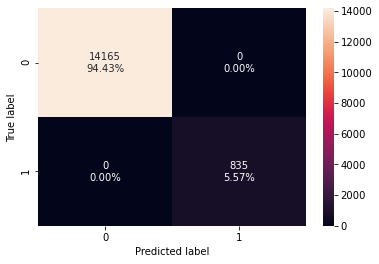

In [42]:
confusion_matrix_sklearn(xgb_tuned_train, X_train, y_train)

In [43]:
# Testing perfomance on validation data
xgb_tuned_val = XGBClassifier(random_state=1,
   subsample= 0.9, scale_pos_weight= 10, n_estimators= 200, learning_rate= 0.2, gamma= 0
)

# Fit the model on training data
xgb_tuned_val.fit(X_val, y_val)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=1, ...)

In [44]:
xgb_ideal_val = model_performance_classification_sklearn(
    xgb_tuned_val, X_val, y_val
)
print("Validation performance:")
xgb_ideal_val

Validation performance:


,Accuracy,Recall,Precision,F1
0,1.000,1.000,1.000,1.000


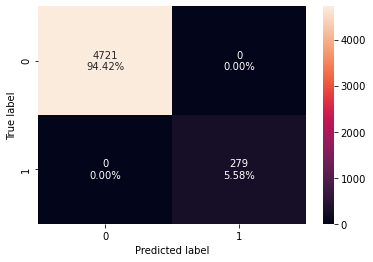

In [45]:
confusion_matrix_sklearn(xgb_tuned_val, X_val, y_val)

#### 2. Oversampled Data

In [46]:
# defining model
over_xgb_model = XGBClassifier(random_state=1, eval_metric="logloss")

# Parameter grid to pass in RandomSearchCV
param_grid = {'n_estimators': [150, 200, 250], 'scale_pos_weight': [5,10], 'learning_rate': [0.1,0.2], 'gamma': [0,3,5], 'subsample': [0.8,0.9]  }


#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=over_xgb_model, param_distributions=param_grid, n_iter=10, n_jobs = -1, scoring=scorer, cv=5, random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train_over,y_train_over)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'subsample': 0.9, 'scale_pos_weight': 10, 'n_estimators': 200, 'learning_rate': 0.2, 'gamma': 0} with CV score=0.9969643487469113:


In [47]:
# building model with best parameters
xgb_tuned_over = XGBClassifier(random_state=1,
   subsample= 0.9, scale_pos_weight= 10, n_estimators= 200, learning_rate= 0.2, gamma= 0
)

# Fit the model on overing data
xgb_tuned_over.fit(X_train_over, y_train_over)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=1, ...)

In [48]:
xgb_ideal_over = model_performance_classification_sklearn(
    xgb_tuned_over, X_train_over, y_train_over
)
print("Oversampled data performance:")
xgb_ideal_over

Oversampled data performance:


,Accuracy,Recall,Precision,F1
0,1.000,1.000,1.000,1.000


#### 3. Undersampled data

In [49]:
# defining model
under_xgb_model = XGBClassifier(random_state=1, eval_metric="logloss")

# Parameter grid to pass in RandomSearchCV
param_grid = {'n_estimators': [150, 200, 250], 'scale_pos_weight': [5,10], 'learning_rate': [0.1,0.2], 'gamma': [0,3,5], 'subsample': [0.8,0.9]  }


#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=under_xgb_model, param_distributions=param_grid, n_iter=10, n_jobs = -1, scoring=scorer, cv=5, random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train_un,y_train_un)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'subsample': 0.9, 'scale_pos_weight': 10, 'n_estimators': 150, 'learning_rate': 0.2, 'gamma': 3} with CV score=0.9125748502994012:


In [50]:
# building model with best parameters
xgb_tuned_un = XGBClassifier(random_state=1,
   subsample= 0.9, scale_pos_weight= 10, n_estimators= 150, learning_rate= 0.2, gamma= 0
)

# Fit the model on uning data
xgb_tuned_un.fit(X_train_un, y_train_un)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=150, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=1, ...)

In [51]:
xgb_ideal_un = model_performance_classification_sklearn(
    xgb_tuned_un, X_train_un, y_train_un
)
print("Undersampled data performance:")
xgb_ideal_un

Undersampled data performance:


,Accuracy,Recall,Precision,F1
0,1.000,1.000,1.000,1.000


#### Observations
* Recall from all models was 1. Model can accurately predict failures.
* Better perfomance than Random Forest models

### Gradient boosting using Random Search Cross Validation

#### 1. Original Data


In [52]:
# defining model
original_gb_model = GradientBoostingClassifier(random_state=1)

# Parameter grid to pass in RandomSearchCV
param_grid = { "n_estimators": np.arange(100,150,25), "learning_rate": [0.2, 0.05, 1], "subsample":[0.5,0.7], "max_features":[0.5,0.7] }
#Calling RandomizedSearchCV
gb_randomized_cv = RandomizedSearchCV(estimator=original_gb_model, param_distributions=param_grid, n_iter=10, n_jobs = -1, scoring=scorer, cv=5, random_state=1)

#Fitting parameters in RandomizedSearchCV
gb_randomized_cv.fit(X_train,y_train)

print("Best parameters are {} with CV score={}:" .format(gb_randomized_cv.best_params_,gb_randomized_cv.best_score_))

Best parameters are {'subsample': 0.7, 'n_estimators': 125, 'max_features': 0.5, 'learning_rate': 0.2} with CV score=0.7532934131736526:


In [53]:
# building model with best parameters
gb_tuned_train = GradientBoostingClassifier(random_state=1,
   subsample= 0.7, n_estimators= 125, max_features= 0.5, learning_rate= 0.2
)

# Fit the model on training data
gb_tuned_train.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=0.2, max_features=0.5,
                           n_estimators=125, random_state=1, subsample=0.7)

In [54]:
# Calculating different metrics on train set
gb_ideal_train = model_performance_classification_sklearn(
    gb_tuned_train, X_train, y_train
)
print("Training performance:")
gb_ideal_train

Training performance:


,Accuracy,Recall,Precision,F1
0,0.995,0.923,0.990,0.955


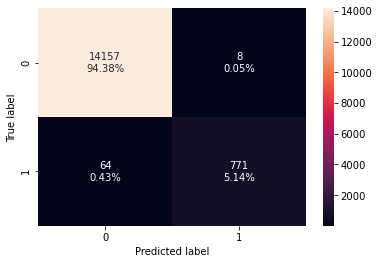

In [55]:
confusion_matrix_sklearn(gb_tuned_train, X_train, y_train)

In [56]:
# Testing perfomance on validation data
gb_tuned_val = GradientBoostingClassifier(random_state=1,
     subsample= 0.7, n_estimators= 125, max_features= 0.5, learning_rate= 0.2

)
# Fit the model on training data
gb_tuned_val.fit(X_val, y_val)

GradientBoostingClassifier(learning_rate=0.2, max_features=0.5,
                           n_estimators=125, random_state=1, subsample=0.7)

In [57]:
gb_ideal_val = model_performance_classification_sklearn(
    gb_tuned_val, X_val, y_val
)
print("Validation performance:")
gb_ideal_val

Validation performance:


,Accuracy,Recall,Precision,F1
0,0.999,0.978,1.000,0.989


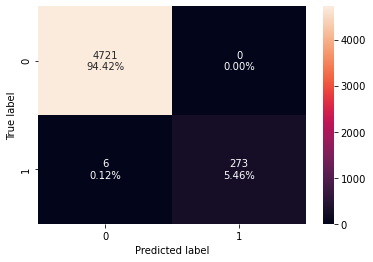

In [58]:
confusion_matrix_sklearn(gb_tuned_val, X_val, y_val)

#### Observations
* Improved recall after tuning. 


#### 2. Oversampled Data

In [59]:
# defining model
over_gb_model = GradientBoostingClassifier(random_state=1)

# Parameter grid to pass in RandomSearchCV
param_grid = { "n_estimators": np.arange(100,150,25), "learning_rate": [0.2, 0.05, 1], "subsample":[0.5,0.7], "max_features":[0.5,0.7] }
#Calling RandomizedSearchCV
over_gb_randomized_cv = RandomizedSearchCV(estimator=over_gb_model, param_distributions=param_grid, n_iter=10, n_jobs = -1, scoring=scorer, cv=5, random_state=1)

#Fitting parameters in RandomizedSearchCV
over_gb_randomized_cv.fit(X_train_over,y_train_over)

print("Best parameters are {} with CV score={}:" .format(over_gb_randomized_cv.best_params_,over_gb_randomized_cv.best_score_))

Best parameters are {'subsample': 0.7, 'n_estimators': 125, 'max_features': 0.5, 'learning_rate': 1} with CV score=0.9705612424991175:


In [60]:
# building model with best parameters
gb_tuned_over = GradientBoostingClassifier(random_state=1,
   subsample= 0.7, n_estimators= 125, max_features= 0.5, learning_rate= 1
)

# Fit the model on overing data
gb_tuned_over.fit(X_train_over, y_train_over)

GradientBoostingClassifier(learning_rate=1, max_features=0.5, n_estimators=125,
                           random_state=1, subsample=0.7)

In [61]:
# Calculating different metrics on over set
gb_ideal_over = model_performance_classification_sklearn(
    gb_tuned_over, X_train_over, y_train_over
)
print("Oversampled data performance:")
gb_ideal_over

Oversampled data performance:


,Accuracy,Recall,Precision,F1
0,0.983,0.981,0.986,0.983


#### Undersampled data

In [62]:
# defining model
under_gb_model = GradientBoostingClassifier(random_state=1)

# Parameter grid to pass in RandomSearchCV
param_grid = { "n_estimators": np.arange(100,150,25), "learning_rate": [0.2, 0.05, 1], "subsample":[0.5,0.7], "max_features":[0.5,0.7] }
#Calling RandomizedSearchCV
under_gb_randomized_cv = RandomizedSearchCV(estimator=under_gb_model, param_distributions=param_grid, n_iter=10, n_jobs = -1, scoring=scorer, cv=5, random_state=1)

#Fitting parameters in RandomizedSearchCV
under_gb_randomized_cv.fit(X_train_un,y_train_un)

print("Best parameters are {} with CV score={}:" .format(under_gb_randomized_cv.best_params_,under_gb_randomized_cv.best_score_))

Best parameters are {'subsample': 0.7, 'n_estimators': 125, 'max_features': 0.5, 'learning_rate': 0.2} with CV score=0.895808383233533:


In [63]:
# building model with best parameters
gb_tuned_un = GradientBoostingClassifier(random_state=1,
   subsample= 0.7, n_estimators= 125, max_features= 0.5, learning_rate= 0.2
)

# Fit the model on uning data
gb_tuned_un.fit(X_train_un, y_train_un)

GradientBoostingClassifier(learning_rate=0.2, max_features=0.5,
                           n_estimators=125, random_state=1, subsample=0.7)

In [64]:
# Calculating different metrics on un set
gb_ideal_un = model_performance_classification_sklearn(
    gb_tuned_un, X_train_un, y_train_un
)
print("Undersampled data performance:")
gb_ideal_un

Undersampled data performance:


,Accuracy,Recall,Precision,F1
0,0.994,0.989,0.999,0.994


#### Observations
* Model trained on original data was the worst perfoming model in terms of recall
* Models trained on unersampled and oversampled data could accurately predict ~0.99% of the failures

## Model performance comparison and choosing the final model

In [65]:
# training performance comparison

models_train_comp_df = pd.concat(
    [
        rf_ideal_train.T,
        rf_ideal_over.T, 
        rf_ideal_un.T,
        xgb_ideal_train.T,
        xgb_ideal_over.T,
        xgb_ideal_un.T,
        gb_ideal_train.T,
        gb_ideal_over.T, 
        gb_ideal_un.T,
        
    ],
    axis=1,
)
models_train_comp_df.columns = [
    "Random Forest(Original Data)",
    "Random Forest(Oversampled Data)",
    "Random Forest(Undersampled Data)",
    "Xgboost (Original Data)",
    "XGBoost(Oversampled Data)",
    "XGBoost(Undersampled Data)",
    "Gradient Boosting(Original Data)",
    "Gradient Boosting(Oversampled Data)",
    "Gradient Boosting(Undersampled Data)",
    
]
print("Training performance comparison:")
models_train_comp_df.T

Training performance comparison:


,Accuracy,Recall,Precision,F1
Random Forest(Original Data),0.995,0.902,1.000,0.948
Random Forest(Oversampled Data),1.000,1.000,1.000,1.000
Random Forest(Undersampled Data),0.988,0.976,1.000,0.988
Xgboost (Original Data),1.000,1.000,1.000,1.000
XGBoost(Oversampled Data),1.000,1.000,1.000,1.000
XGBoost(Undersampled Data),1.000,1.000,1.000,1.000
Gradient Boosting(Original Data),0.995,0.923,0.990,0.955
Gradient Boosting(Oversampled Data),0.983,0.981,0.986,0.983
Gradient Boosting(Undersampled Data),0.994,0.989,0.999,0.994


In [66]:
#Perfomance on validation data
models_val_comp_df = pd.concat(
    [
       
        rf_ideal_val.T,
        xgb_ideal_val.T,
        gb_ideal_val.T
    ],
    axis=1,
)
models_val_comp_df.columns = [
    "Tuned Random Forest",
    "Tuned Xgboost ",
    "Tuned Gradient Boost",
]
print("Validation performance comparison:")
models_val_comp_df

Validation performance comparison:


,Tuned Random Forest,Tuned Xgboost,Tuned Gradient Boost
Accuracy,0.993,1.000,0.999
Recall,0.875,1.000,0.978
Precision,1.000,1.000,1.000
F1,0.933,1.000,0.989


#### Observation
* Based on the perfomance, XGBoost model is chosen

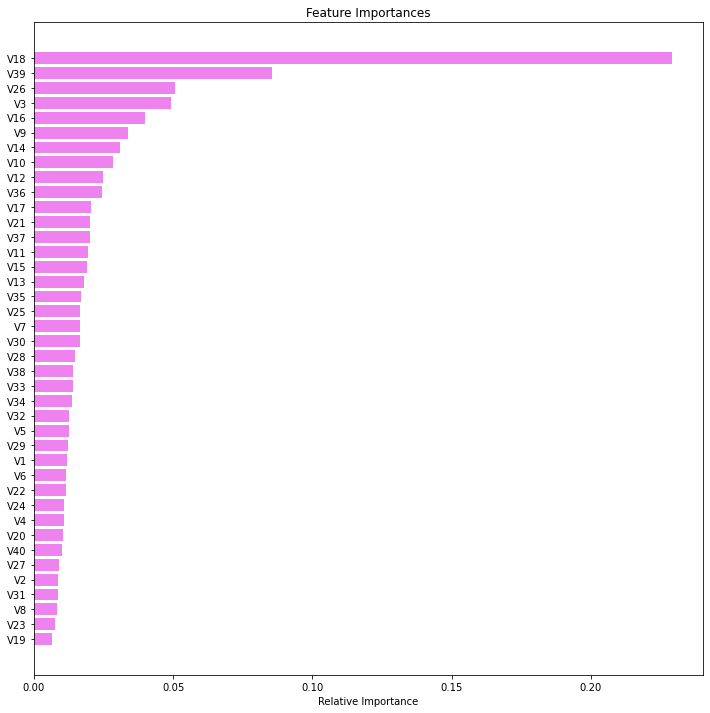

In [67]:
feature_names = X_train.columns
importances = xgb_tuned_train.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(12, 12))
plt.title("Feature Importances")
plt.barh(range(len(indices)), importances[indices], color="violet", align="center")
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel("Relative Importance")
plt.show()

### Test set final performance

In [68]:
# building model with best parameters
xgb_ideal_test = XGBClassifier(
   subsample= 0.9, scale_pos_weight= 10, n_estimators= 200, learning_rate= 0.2, gamma= 0
)

xgb_ideal_test.fit(X_test, y_test)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=200, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [69]:
# Calculating different metrics on train set
xgb_ideal_test = model_performance_classification_sklearn(
    xgb_ideal_test, X_test, y_test
)
print("Testing performance:")
xgb_ideal_test

Testing performance:


,Accuracy,Recall,Precision,F1
0,1.000,1.000,1.000,1.000


## Pipelines to build the final model


In [71]:
# Separating target variable and other variables
X = data.drop("Target", axis=1)
Y = data["Target"]

In [72]:
# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.30, random_state=1, stratify=Y
)
print(X_train.shape, X_test.shape)

(17500, 40) (7500, 40)


#### Observations
* The training data contains 17500 rows and 40 columns
* The testing data contains 7500 rows and 40 columns

In [73]:
# Creating new pipeline with best parameters
model = Pipeline(
    steps=[
        ("fill_missing",  SimpleImputer(strategy="median")),
        (
            "XGB",
            XGBClassifier(
                subsample= 0.9, scale_pos_weight= 10, n_estimators= 200, learning_rate= 0.2, gamma= 0
            ),
        ),
    ]
)
# Fit the model on training data
model.fit(X_train, y_train)

Pipeline(steps=[('fill_missing', SimpleImputer(strategy='median')),
                ('XGB',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=0, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=0.2,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=200,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=None, ...))])

In [74]:
Model_test = model_performance_classification_sklearn(model, X_test, y_test)
Model_test

,Accuracy,Recall,Precision,F1
0,0.989,0.835,0.967,0.896


# Business Insights and Conclusions

1. The final model built using XGBoost can accurately predict ~84% of generator failures<br/>
2. The 5 variables that affect the failure rate of the generators are:<br/>
    * V18
    * V39
    * V26
    * V3
    * V16
3. V39 is aslo affected by the variable V36. This is because they have a positve correlation of 0.75. If the value of one is increased by 1 units, the other variable will have 0.75 increase <br/>
4. V26 has a positive correlation with 0.79 with V2. If V26 is increased by 1 unit, V2 will increase by 0.79

***